# All imports

In [443]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, balanced_accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import scipy as sc
from scipy.stats import multivariate_t, t, multivariate_normal
from scipy.special import loggamma, expit
from scipy.optimize import minimize
import sys
from collections import Counter

# Classification Problem

## Exploratory Analysis

### Reading in Dataset

In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
df = pd.read_csv('heart.csv')

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Dataset analysis

In [5]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [526]:
# Select all numerical columns
target_feature = ["HeartDisease"]
numerical_covariates = df.select_dtypes(include=["int64", "float64"]).columns.drop(["HeartDisease", "FastingBS"])
numerical_covariates_with_target = df.select_dtypes(include=["int64", "float64"]).columns.drop("FastingBS")
categorical_covariates = df.select_dtypes(include=["object"]).columns.tolist()
categorical_covariates.append("FastingBS")

print("Numerical Covariates:", numerical_covariates.values)
print("Categorical Covariates:", categorical_covariates)
print("Balance of target column:", df[target_feature].value_counts())

Numerical Covariates: ['Age' 'RestingBP' 'Cholesterol' 'MaxHR' 'Oldpeak']
Categorical Covariates: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
Balance of target column: HeartDisease
1               508
0               410
Name: count, dtype: int64


We can see there are
- 5 numerical covariates
- 6 categorical covariates
    - Sex: 2 categories
    - ChestPainType: 4 categories
    - RestingECG: 3 categories
    - ExerciseAngina: 2 categories
    - ST_Slope: 3 categories
    - FastingBS: 2 categories

#### Correlation matrix of all numerical features

NOTE: We can see a lot of redundant samples with cholesterol being 0.

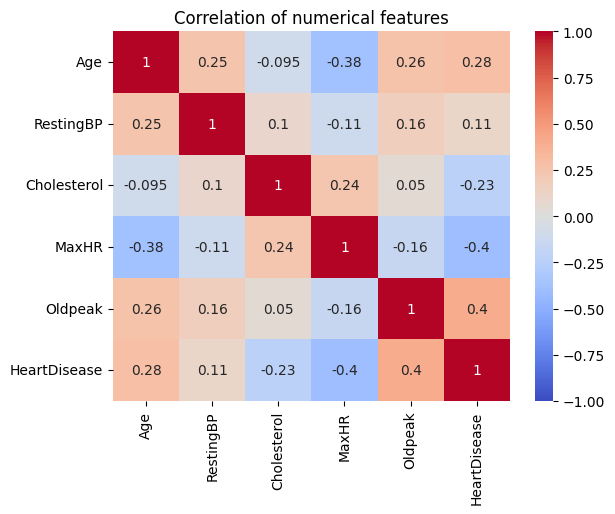

/Users/shreyashonnalli/venv-metal/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shreyashonnalli/venv-metal/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/shreyashonnalli/venv-metal/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/shreyashonnalli/venv-metal/lib/python3.10

[]

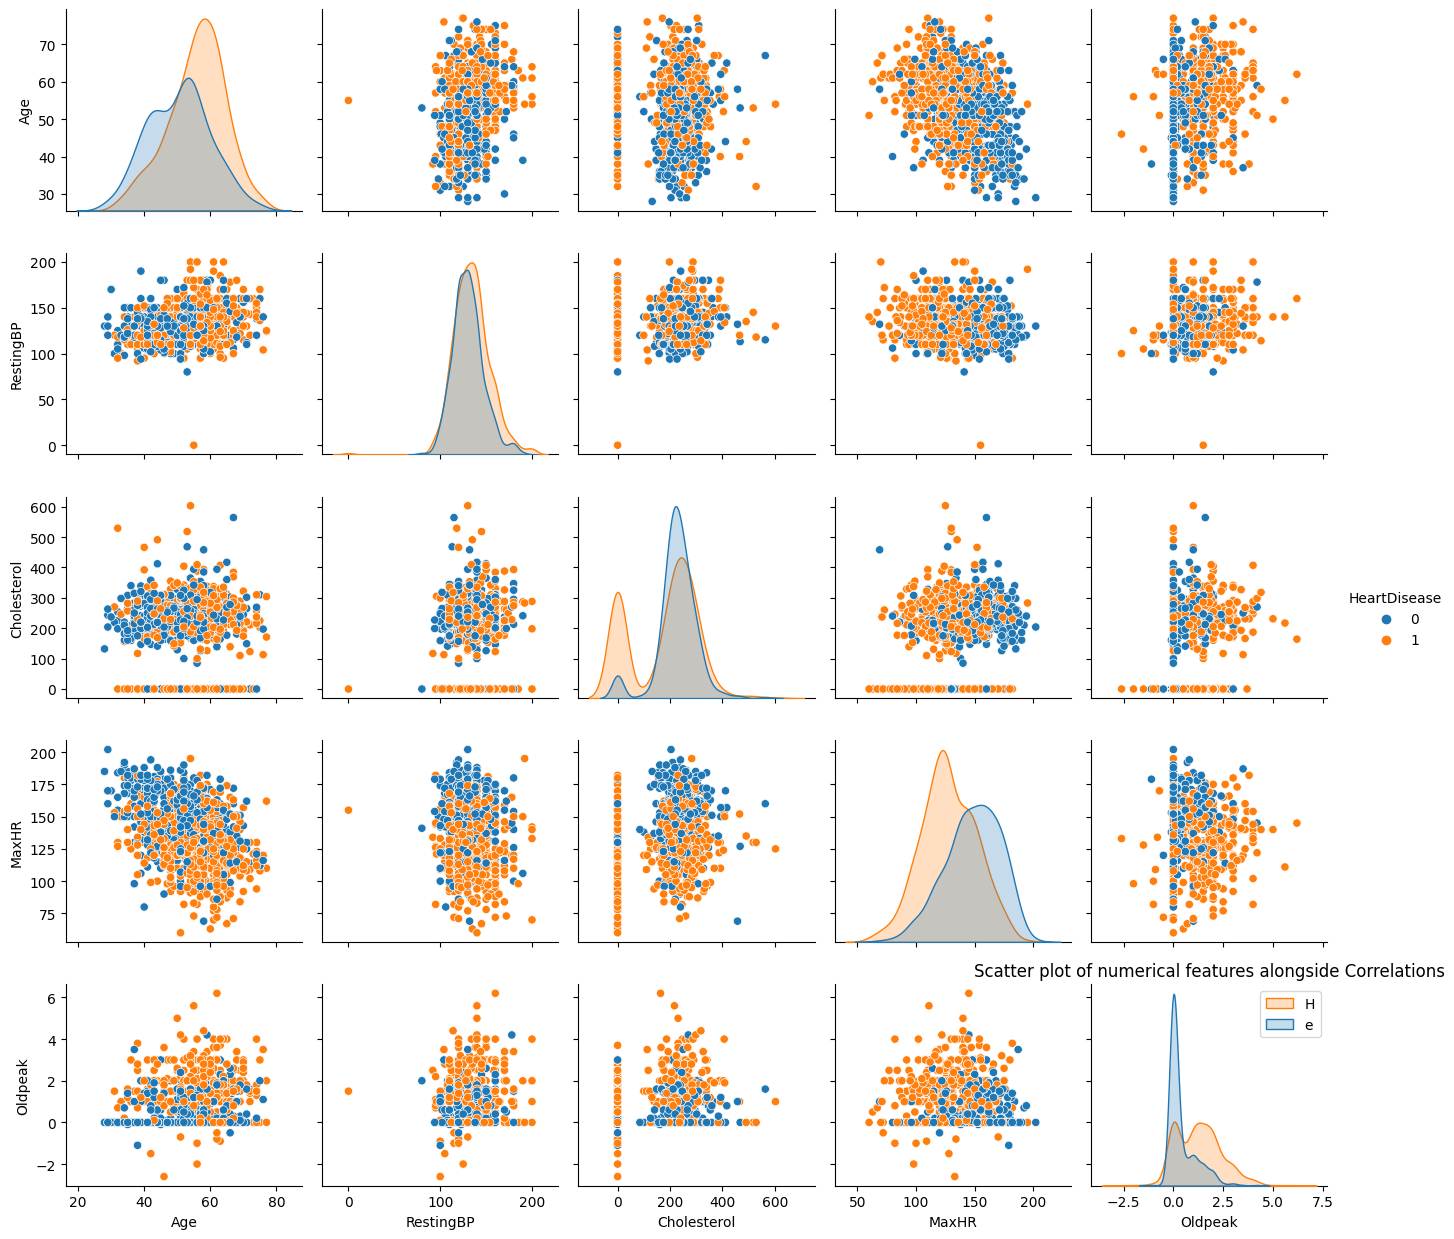

In [24]:
corr = df[numerical_covariates_with_target].corr()
plt.figure()
sns.heatmap(corr, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Correlation of numerical features')
plt.show()


pp = sns.pairplot(df[numerical_covariates_with_target], hue='HeartDisease')
plt.title("Scatter plot of numerical features alongside Correlations")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

#### Categorical Variable Analysis - Proportion plots

We first calculate the proportion of the target within each category of each categorical feature, and then plot the proportions within each category via a bar chart. This approach is better than comparing raw counts of the target variable within each category, because there may be imbalances of the counts of each covariate category.

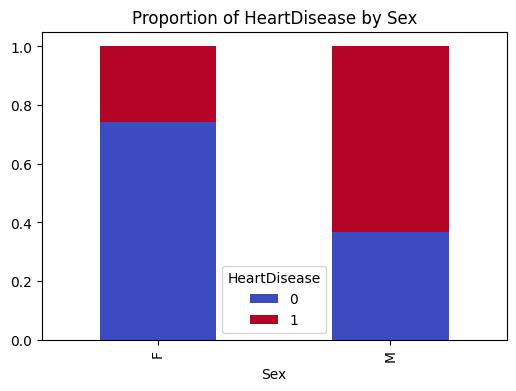

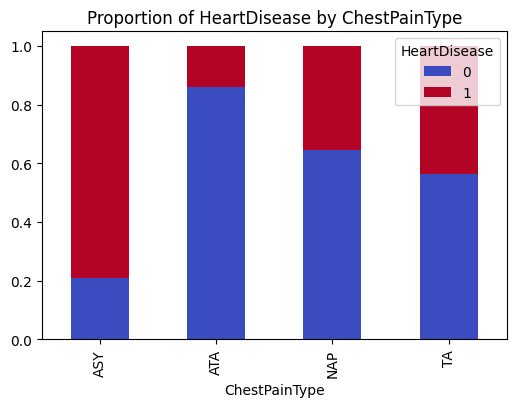

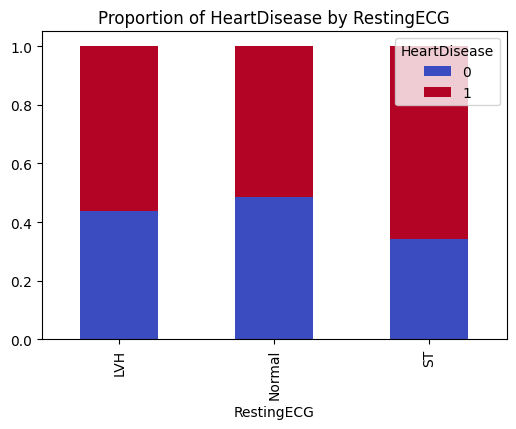

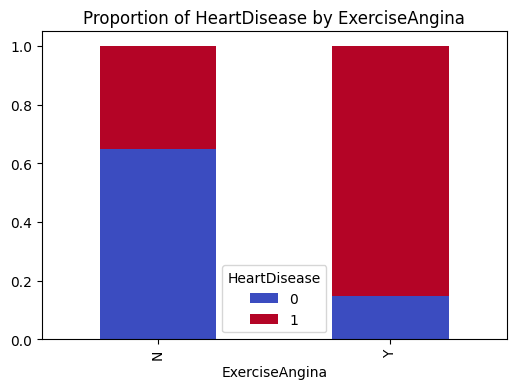

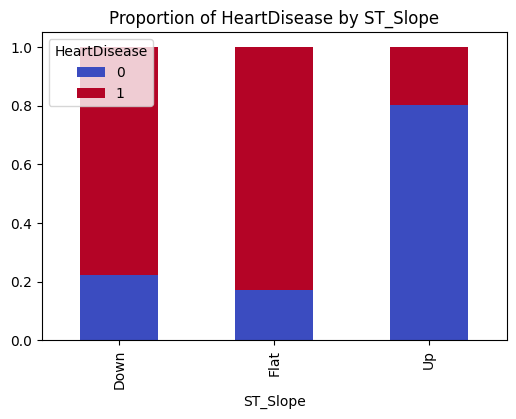

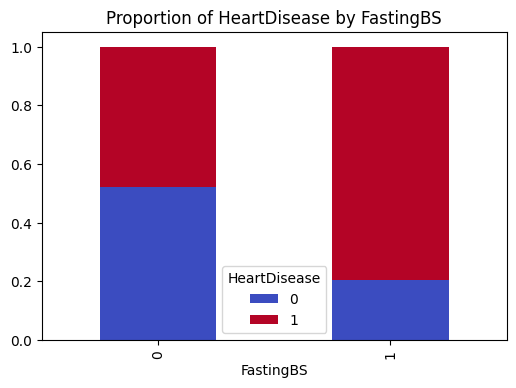

In [50]:
for col in categorical_covariates:
    prop_df = (
        df.groupby(col)["HeartDisease"]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )
    stacked_df = prop_df.pivot(index=col, columns="HeartDisease", values="proportion").fillna(0)
    
    stacked_df.plot(kind="bar", stacked=True, figsize=(6, 4), colormap="coolwarm")
    plt.title(f"Proportion of HeartDisease by {col}")
    plt.xticks()
    plt.show()

#### Finding erroneous rows

In [77]:
print("Looking for null values in each column:")
print((df.isnull().sum()))
print("\nLooking for 0 values in numerical columns:")
print((df[numerical_covariates]==0).sum())

Looking for null values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Looking for 0 values in numerical columns:
Age              0
RestingBP        1
Cholesterol    172
MaxHR            0
Oldpeak        368
dtype: int64


## Data Splitting

In [521]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=True, random_state=1, stratify=y_temp)

## Data Cleaning

We have clearly identified 1 source of incorrect data: numerical columns cholesterol and RestingBP equals 0. Looking at the pairplot and combining contextual knowledge, these values having 0 is clearly a fault in a data collection method, due to the following reasons:
- Having a cholesterol of 0 is impossible, as all humans have some degree of cholesterol.
- A resting blood pressure (systolic) of 0 mmHg would indicate no blood circulation — which is not compatible with life.

NOTE: The variable OldPeak typically refers to ST depression caused by exercise. It's a measure taken during a stress test, such as a treadmill exercise. It represents the difference between ST segment height at rest and after exercise. OldPeak having value of 0 is NOT abnormal.
- OldPeak = 0.0 means no ST Depression = normal response
- OldPeak = 2.3 indicates significant Depression = possible heart disease

In [232]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, subset=None, keep='first'):
        pass

    def reset_indices(self, X_cleaned, y_cleaned):
        return X_cleaned.reset_index(drop = True), y_cleaned.reset_index(drop = True)
    
    def remove_rows_with_0_column(self, X, y, col_name):
        non_zero_mask = X[col_name] != 0
        X_filtered = X[non_zero_mask]
        y_filtered = y[non_zero_mask]
        X_filtered, y_filtered = self.reset_indices(X_filtered, y_filtered)
        return X_filtered, y_filtered
    
    def fit(self, X, y):
        return self

    def transform(self, X, y):
        X_cleaned, y_cleaned = self.remove_rows_with_0_column(X, y, "Cholesterol")
        X_cleaned, y_cleaned = self.remove_rows_with_0_column(X_cleaned, y_cleaned, "RestingBP")
        return X_cleaned, y_cleaned

binary_cats = [col for col in categorical_covariates if df[col].nunique() == 2]
multi_cats = [col for col in categorical_covariates if df[col].nunique() > 2]

# We drop the first column after doing one-hot encoding to avoid perfect collinearity among covariates
preprocessor = ColumnTransformer(transformers=[
    ('binary', OneHotEncoder(drop='first', sparse_output=False), binary_cats),
    ('multi', OneHotEncoder(drop='first', sparse_output=False), multi_cats),
    # ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_covariates),
    # ('num', StandardScaler(), numerical_covariates),
    ('num', Normalizer(), numerical_covariates)
], remainder='passthrough')

full_pipeline = Pipeline([
    ('preprocess', preprocessor),
    # ('model', RandomForestRegressor())
])

In [522]:
dc = DataCleaner()


X_train_cleaned, y_train_cleaned = dc.transform(X = X_train, y = y_train)
X_val_cleaned , y_val_cleaned = dc.transform(X = X_val, y = y_val)
X_test_cleaned , y_test_cleaned = dc.transform(X = X_test, y = y_test)

X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
X_val_preprocessed = full_pipeline.fit_transform(X_val_cleaned, y_val_cleaned)
X_test_preprocessed = full_pipeline.fit_transform(X_test_cleaned, y_test_cleaned)

print("Dataset size:")
print(len(X_train_preprocessed) + len(X_val_preprocessed) + len(X_test_preprocessed))
print("\nTraining:")
print(X_train_preprocessed.shape)
print(y_train_cleaned.shape)
print("\nValidation")
print(X_val_preprocessed.shape)
print(y_val_cleaned.shape)
print("\nTesting:")
print(X_test_preprocessed.shape)
print(y_test_cleaned.shape)

Dataset size:
746

Training:
(448, 15)
(448,)

Validation
(144, 15)
(144,)

Testing:
(154, 15)
(154,)


## Model Training

### Model Selection Functions

The following functions are explained below whenever they are utilized.

#### K-Fold Cross Validation

In [346]:
def k_fold_cross_validation(full_pipeline, X_train_cleaned, y_train_cleaned, scoring, model, n_splits=5):
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_preprocessed, y_train_cleaned, cv = cv, scoring=scoring)
    return scores

    
def k_fold_cross_validation_most_significant_covariates(full_pipeline, X_train_cleaned, y_train_cleaned, scoring, model, n_splits=5, k=4):
    def get_covariates_appearing_atleast_k_times(significant_covs_in_splits, k = n_splits-1):
        if k > n_splits: return
        counter = Counter()
        for arr in significant_covs_in_splits:
            counter.update(arr)
            
        covariates_at_least_k = sorted([item for item, count in counter.items() if count >= k])
        covariates_at_least_k = np.array(covariates_at_least_k)
        return covariates_at_least_k
    
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    significant_covs = []

    for train_idx, val_idx in cv.split(X_train_preprocessed):
        X_train_fold, X_val_fold = X_train_preprocessed[train_idx, :], X_train_preprocessed[val_idx, :]
        y_train_fold, y_val_fold = y_train_cleaned[train_idx], y_train_cleaned[val_idx]
        
        X_train_fold = sm.add_constant(X_train_fold)
        X_val_fold = sm.add_constant(X_val_fold)
        
        model = sm.Logit(y_train_fold, X_train_fold)
        result = model.fit(disp=0)
        
        significant_features = np.where(result.pvalues <= 0.05)[0]
        
        X_train_fold_selected = X_train_fold[:, significant_features]
        X_val_fold_selected = X_val_fold[:, significant_features]
        
        model_selected = sm.Logit(y_train_fold, X_train_fold_selected)
        result_selected = model_selected.fit(disp=0)
        
        y_pred_val = result_selected.predict(X_val_fold_selected)
        
        if scoring == 'roc_auc':
            score = roc_auc_score(y_val_fold, y_pred_val)
        
        scores.append(score)
        significant_covs.append(significant_features)
        
    significant_covs = get_covariates_appearing_atleast_k_times(significant_covs, k=k)
    return scores, significant_covs
        

#### Bayesian Model Evidence Based Selection

In [504]:
def bayesian_model_evidence_selection(full_pipeline, X_train_cleaned, y_train_cleaned, BayesianLogisticRegressionClass, num_models = 10, seed = 1):
    np.random.seed(seed)
    X_train_preprocessed = full_pipeline.fit_transform(X_train_cleaned, y_train_cleaned)
    param_indices = list(range(X_train_preprocessed.shape[1]))
    
    all_subsets = []
    all_evidences = []
    best_subset = []
    highest_evidence = -sys.maxsize - 1
    
    for i in range(num_models):
        subset_size = np.random.randint(1, len(param_indices))
        
        if i == 0:
            subset = list(range(X_train_preprocessed.shape[1]))
        else:
            subset = np.random.choice(param_indices, subset_size, replace=False)
        subset = sorted(subset)
        
        blr = BayesianLogisticRegressionClass(
                                beta_0 = np.zeros(len(subset) + 1),
                                m_0 = np.zeros(len(subset) + 1),
                                sigma_0_inv= (X_train_preprocessed[:, subset].T @ X_train_preprocessed[:, subset])/ X_train_preprocessed.shape[0],
                                maxiter=100,
                                tolerance=1e-05,
                                fit_intercept=True,
                                unit_information_prior=True,
                                verbose = 0
                                )
        
        blr.fit(X_train_preprocessed[:, subset], y_train_cleaned[:])
        
        if blr.log_model_evidence > highest_evidence:
            highest_evidence = blr.log_model_evidence
            best_subset = subset

        all_subsets.append(subset)
        all_evidences.append(blr.log_model_evidence)
        
        print("Finished calculating evidence for subset number:", i+1)
    
    return highest_evidence, best_subset, all_evidences, all_subsets

### Model Evaluation Class

This class is used to evaluate performance on a particular dataset, and takes in a fitted model. For example, evaluating performance on validation or test set and takes in fitted model on training set. It calculates all sorts of classification metrics and curves, comprehensively evaluating performance.

In [512]:
class ClassificationEvaluator(ABC):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        self.model = model
        self.feature_names = feature_names
        self.real = y_evaluation_cleaned 
        self.preds = self.model.predict(X_evaluation_preprocessed[:, :])
        self.pred_probabilities = self.model.predict_proba(X_evaluation_preprocessed[:, :])
    
    @abstractmethod
    def plot_coefficients(self):
        pass
    
    @abstractmethod
    def get_coefficient_statistics(self):
        pass

    # Raw Accuracy, Balanced Accuracy, Sensitivity, Specificity, Precision, False Alarm Rate, F-Score
    def get_metrics(self):
        accuracy = accuracy_score(self.real, self.preds)
        precision = precision_score(self.real, self.preds)
        recall = recall_score(self.real, self.preds)
        
        tn, fp, fn, tp = confusion_matrix(self.real, self.preds).ravel()
        specificity = tn / (tn + fp)
        false_alarm_rate = fp / (tn + fp)
        f1 = f1_score(self.real, self.preds)
        balanced_accuracy = balanced_accuracy_score(self.real, self.preds)
        
        return {
            'Accuracy': accuracy,
            'Balanced accuracy': balanced_accuracy,
            'Precision': precision,
            'Sensivity/Recall': recall,
            'Specificity': specificity,
            'False Alarm Rate': false_alarm_rate,
            'F1 Score': f1
            }
        
    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.real, self.preds)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
        
    def plot_roc_curve(self):
        y_preds_label1_probability = self.pred_probabilities[:, 1]
        fpr, tpr, thresholds = roc_curve(self.real, y_preds_label1_probability)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1-specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def plot_pr_curve(self):
        y_preds_label1_probability = self.pred_probabilities[:, 1]
        precision, recall, thresholds = precision_recall_curve(self.real, y_preds_label1_probability)
        ap_score = average_precision_score(self.real, y_preds_label1_probability)

        plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})', color='green')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    def get_all_classification_metrics(self):
        metrics = self.get_metrics()
        print(metrics)
        self.plot_coefficients()
        self.plot_confusion_matrix()
        self.plot_roc_curve()
        self.plot_pr_curve()
        self.get_coefficient_statistics()
        pass
    
class LogisticRegressionClassificationEvaluator(ClassificationEvaluator):
    def __init__(self, model, x_evaluation_preprocessed, y_evaluation_cleaned, feature_names, stats_model):
        self.stats_model = stats_model
        super().__init__(model, x_evaluation_preprocessed, y_evaluation_cleaned, feature_names)
    
    def plot_coefficients(self): 
        coefficients = self.model.coef_[0]
        plt.bar(range(len(self.feature_names)), np.abs(coefficients))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.xlabel('Coefficient')
        plt.ylabel('Absolute value - log scale')
        plt.yscale('log')
        plt.show()
        
    def get_coefficient_statistics(self):
        results = self.stats_model.fit(method='ncg',maxiter=30000)
        print(results.summary())
        print()

        
class BayesianLogisticRegressionClassificationEvaluator(ClassificationEvaluator):
    def __init__(self, model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        super().__init__(model, X_evaluation_preprocessed, y_evaluation_cleaned, feature_names)
        
    def plot_coefficients(self):
        coefficients = self.model.coef_
        self.feature_names = pd.Index(['intercept']).append(self.feature_names)
        plt.bar(range(len(self.feature_names)), np.abs(coefficients))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.xlabel('Coefficient')
        plt.ylabel('Absolute value - log scale')
        plt.yscale('log')
        plt.show()
        return 

    def get_coefficient_statistics(self):
        pd.set_option('display.width', None)
        pd.set_option('display.max_columns', None)
        print(self.model.get_summary().to_string())
        print()
    
class GaussianProcessClassificationEvaluator(ClassificationEvaluator):
    def __init__(self, model, x_evaluation_preprocessed, y_evaluation_cleaned, feature_names):
        super().__init__(model, x_evaluation_preprocessed, y_evaluation_cleaned, feature_names)

    def _plot_coefficient_plotter(self, importance):
        plt.bar(range(len(self.feature_names)), np.abs(importance))
        plt.xticks(range(len(self.feature_names)),self.feature_names[:len(self.feature_names)],rotation=-45)
        plt.title("GP Feature Importance (1 / Length Scale)")
        plt.xlabel('Coefficient')
        plt.ylabel('Feature Importance (log scale)')
        plt.yscale('log')
        plt.show()

    def get_coefficient_statistics(self):
        return super().get_coefficient_statistics()
    
    def plot_coefficients(self):
        kernel_params = self.model.kernel_.get_params()
        length_scale_params = []
        for kp_key in kernel_params:
            if kp_key.endswith("length_scale"):
                length_scale_params.append(kp_key)
        
        for i in range(len(length_scale_params)):
            coefficients = kernel_params[length_scale_params[i]]
            if isinstance(coefficients, np.float64):
                print("Isotropic kernel with length_scale value:", coefficients)
                continue
            importance = 1 / coefficients
            self._plot_coefficient_plotter(importance)

### Gaussian Process Classification

#### Cross Validation to find best Gaussian Process Kernel

Unlike regression, we don't need to do sub-sampling and can do traditional k-fold cross validation. This is because the dataset is much smaller in this case. The training dataset has only 448 samples. We conduct 5-fold cross validation. to compare 2 kernels - RBF and Rational Quadratic. We add a constant to this kernel controlling for scale, and also white noise allowing for erroneous measurements. We use ROC-AUC as the metric across the different folds. We take the model with the highest average ROC-AUC across the splits. We do this because of a slight imbalance in the target variable, with there being ~500 positive samples and ~400 negative samples. Using ROC-AUC as a metric allows us to account for both Sensitivity and Specificity and choose a model maximizing both.

In [162]:
kernel = 1.0**2 * RBF(length_scale=1) # RBF kernel with default parameters
gp = GaussianProcessClassifier(kernel=kernel)

NOTE: Below cell took ~5 mins to run on Apple MacBook M1 Air

In [170]:
cv_scores_gp_rbf_all_cols = k_fold_cross_validation(full_pipeline = full_pipeline, 
                                                X_train_cleaned=X_train_cleaned, 
                                                y_train_cleaned=y_train_cleaned, 
                                                scoring='roc_auc', 
                                                model = GaussianProcessClassifier(kernel = 
                                                                                  ConstantKernel(constant_value=1,
                                                                                                constant_value_bounds=(1e+1, 1e+10)
                                                                                                )
                                                                                  * RBF(length_scale=1.0, 
                                                                                      length_scale_bounds=(1e-10, 100)
                                                                                      )
                                                                                  + WhiteKernel(noise_level=1 ** 2, 
                                                                                              noise_level_bounds=(1e-10, 1e+10)
                                                                                              )
                                                                                  ), 
                                                numeric_cols_only=False, 
                                                n_splits=5)
print(cv_scores_gp_rbf_all_cols)

[0.8939 0.9402 0.9313 0.9329 0.9292]


NOTE: Below cell took ~7 mins to run on Apple MacBook M1 Air

In [ ]:
cv_scores_gp_rq_all_cols = k_fold_cross_validation(full_pipeline = full_pipeline, 
                                                X_train_cleaned=X_train_cleaned, 
                                                y_train_cleaned=y_train_cleaned, 
                                                scoring='roc_auc', 
                                                model = GaussianProcessClassifier(kernel = 
                                                                                  ConstantKernel(constant_value=1,
                                                                                                constant_value_bounds=(1e+1, 1e+10)
                                                                                                )
                                                                                  * RationalQuadratic(length_scale=1.0,
                                                                                                      alpha=1.0,
                                                                                                      alpha_bounds=(1e-10, 1e+10)
                                                                                                      )
                                                                                  + WhiteKernel(noise_level=1 ** 2, 
                                                                                              noise_level_bounds=(1e-10, 1e+10)
                                                                                              )
                                                                                  ), 
                                                numeric_cols_only=False,
                                                n_splits=5)
print(cv_scores_gp_rq_all_cols)

/Users/shreyashonnalli/venv-metal/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[0.8939 0.9402 0.9313 0.9329 0.9292]


#### Retraining on training set and seeing performance on Validation Set

We take the best performing kernel across different splits, refit on the entire training dataset, and see performance on unseen validation set.

In [ ]:
kernel = ConstantKernel(constant_value=1,constant_value_bounds=(1e+1, 1e+10)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 100)) + WhiteKernel(noise_level=1 ** 2, noise_level_bounds=(1e-5, 1e+10))
gp = GaussianProcessClassifier(kernel=kernel)
gp.fit(X_train_preprocessed, y_train_cleaned)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

{'Accuracy': 0.8571428571428571, 'Balanced accuracy': 0.8580590717299579, 'Precision': 0.8271604938271605, 'Sensivity/Recall': 0.8933333333333333, 'Specificity': 0.8227848101265823, 'False Alarm Rate': 0.17721518987341772, 'F1 Score': 0.8589743589743589}
Isotropic kernel with length_scale value: 6.738348187535608


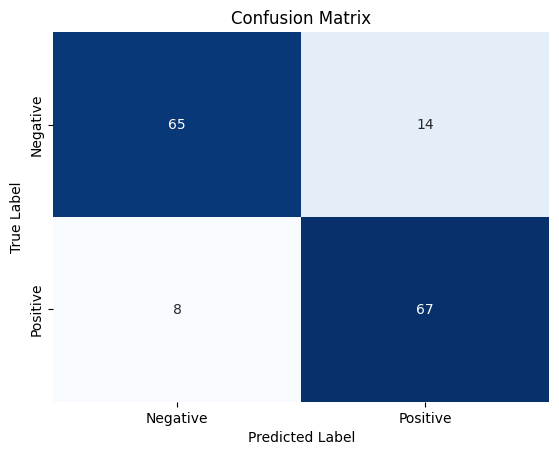

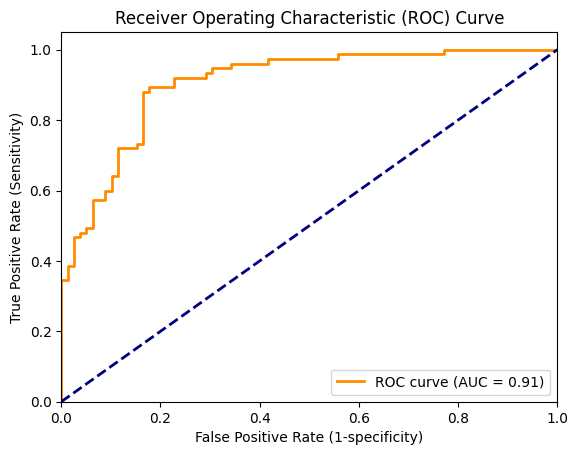

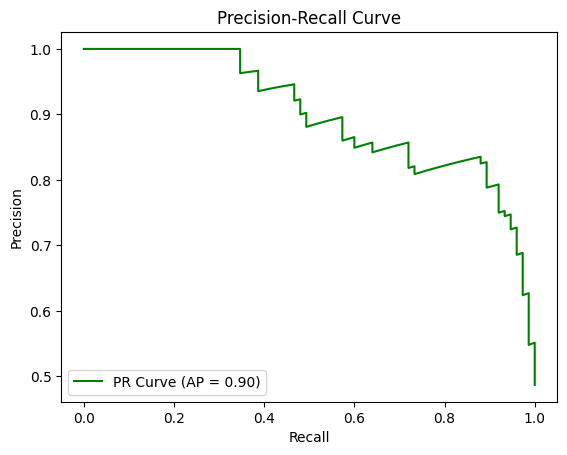

In [ ]:
classification_evaluator_gp = GaussianProcessClassificationEvaluator(model=gp,
                                                                     x_evaluation_preprocessed=X_val_preprocessed,
                                                                     y_evaluation_cleaned=y_val_cleaned,
                                                                     feature_names=X_train_cleaned.columns)

classification_evaluator_gp.get_all_classification_metrics()

### Logistic Regression Classification

#### Cross Validation
We utilize cross validation to compare 2 models
- One is using all covariates.
- Second model utilizes only statistically significant covariates in each split.
    - It returns scores and covariates which are statistically significant in at least $k$ of the n_splits.

##### Cross validation using all covariates

In [438]:
cv_scores_log_reg_all_cols = k_fold_cross_validation(full_pipeline, X_train_cleaned, y_train_cleaned, 'roc_auc', model = LogisticRegression(penalty=None, solver='newton-cg'), n_splits=5)
print("Cross Validation scores (ROC_AUC):", cv_scores_log_reg_all_cols)
print("Mean of Cross Validation scores (ROC_AUC):", np.mean(cv_scores_log_reg_all_cols))

Cross Validation scores (ROC_AUC): [0.8879 0.9380 0.9283 0.9319 0.9246]
Mean of Cross Validation scores (ROC_AUC): 0.922149725922735


##### Cross-Validation of only statistically significant covariates

This corresponds to the second cross-validation function. The workflow is as follows:
1. Take a single training fold and validation fold, and fit the a Logistic Regression model on the training fold using all covariates
2. Look at the statistical significance of each of the covariates, and record only the significant covariates
3. Refit the model on the training fold using **only** statistically significant covariates
4. Use this model to predict on validation fold, and get ROC AUC metric
5. Record the indices of the statistically significant covariates of this split.
6. After getting all scores for all folds, return the set of covariates which were statistically significant in at least $k$ of the n_splits number of splits, where $1 < k < $ n_splits, and the corresponding metric scores.

In [439]:
cv_scores_log_reg_sig_covs, sig_covs = k_fold_cross_validation_most_significant_covariates(full_pipeline, X_train_cleaned, y_train_cleaned, 'roc_auc', model = LogisticRegression(penalty=None, solver='newton-cg'), n_splits=5, k=4)
print("Cross Validation scores (ROC_AUC):", cv_scores_log_reg_sig_covs)
print("Mean of Cross Validation scores (ROC_AUC):",np.mean(cv_scores_log_reg_sig_covs))
print("Signficant covariate indices (including intercept): ", sig_covs)

Cross Validation scores (ROC_AUC): [0.7616892911010558, 0.8496767241379309, 0.8887506222000996, 0.9215686274509803, 0.8838461538461538]
Mean of Cross Validation scores (ROC_AUC): 0.8611062837472442
Signficant covariate indices (including intercept):  [ 1  2  4  5 15]


#### Testing both models on Validation set
We have seen the performance of both models via cross validation. The model using all covariates appears to do better than the model using only statistically significant covariates. We will now see performances on the validation set of both models, after retraining models on the entire training set. We have a list of covariates which have appeared to be statistically significant at least k times across n_splits number of cross validation splits. We will use these covariates only to train a logistic regression model utilizing only statistically significant covariates.

##### All covariates on validation set

In [440]:
log_reg = LogisticRegression(penalty=None, solver='newton-cg')
log_reg.fit(X_train_preprocessed, y_train_cleaned)

LogisticRegression(penalty=None, solver='newton-cg')

{'Accuracy': 0.8541666666666666, 'Balanced accuracy': 0.8549137429734444, 'Precision': 0.8285714285714286, 'Sensivity/Recall': 0.8656716417910447, 'Specificity': 0.8441558441558441, 'False Alarm Rate': 0.15584415584415584, 'F1 Score': 0.8467153284671532}


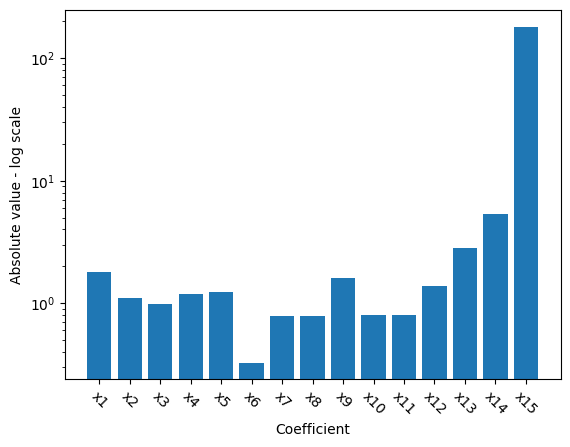

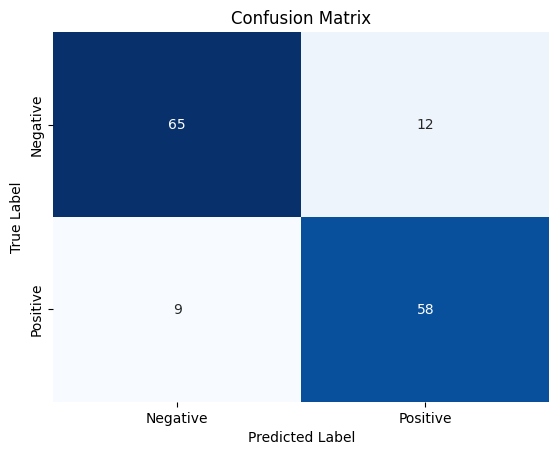

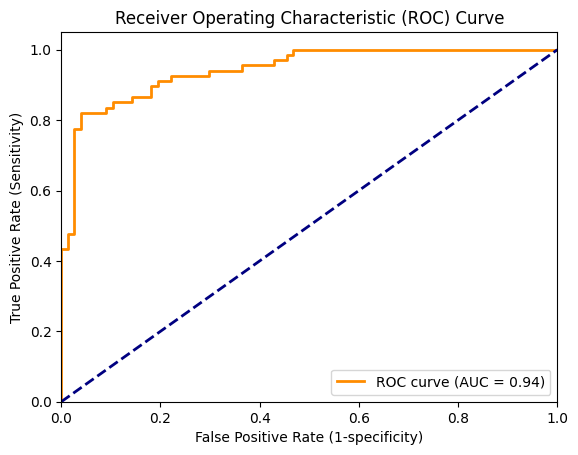

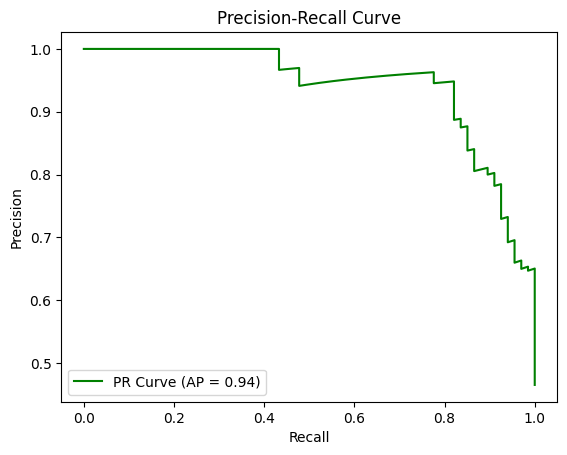

Optimization terminated successfully.
         Current function value: 0.321327
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
         Hessian evaluations: 14
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  448
Model:                          Logit   Df Residuals:                      432
Method:                           MLE   Df Model:                           15
Date:                Sun, 13 Apr 2025   Pseudo R-squ.:                  0.5358
Time:                        10:45:51   Log-Likelihood:                -143.95
converged:                       True   LL-Null:                       -310.08
Covariance Type:            nonrobust   LLR p-value:                 1.069e-61
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [441]:
classification_evaluator_log_reg = LogisticRegressionClassificationEvaluator(model=log_reg,
                                                                     x_evaluation_preprocessed=X_val_preprocessed,
                                                                     y_evaluation_cleaned=y_val_cleaned,
                                                                     feature_names=[f'x{i}' for i in range(1, 16)],
                                                                     stats_model=sm.Logit(y_train_cleaned, sm.add_constant(X_train_preprocessed[:, :])))
                                                            
classification_evaluator_log_reg.get_all_classification_metrics()

##### Statistically significant covariates on validation set

In [435]:
log_reg_sig_covs = LogisticRegression(penalty=None, solver='newton-cg')
log_reg_sig_covs.fit(X_train_preprocessed[:, sig_covs-1], y_train_cleaned)

LogisticRegression(penalty=None, solver='newton-cg')

{'Accuracy': 0.8263888888888888, 'Balanced accuracy': 0.82409381663113, 'Precision': 0.828125, 'Sensivity/Recall': 0.7910447761194029, 'Specificity': 0.8571428571428571, 'False Alarm Rate': 0.14285714285714285, 'F1 Score': 0.8091603053435115}
[1.4062 1.6559 -1.5360 -1.1931 287.6941]


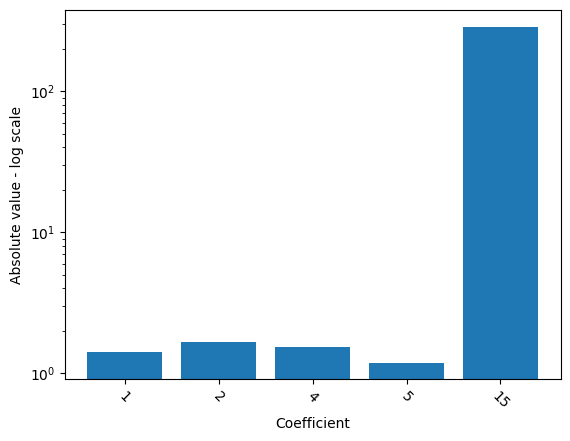

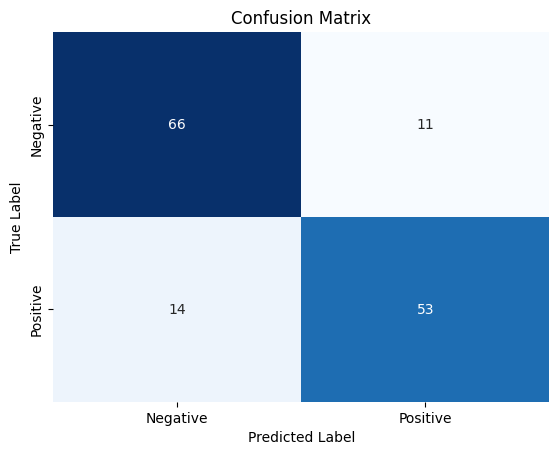

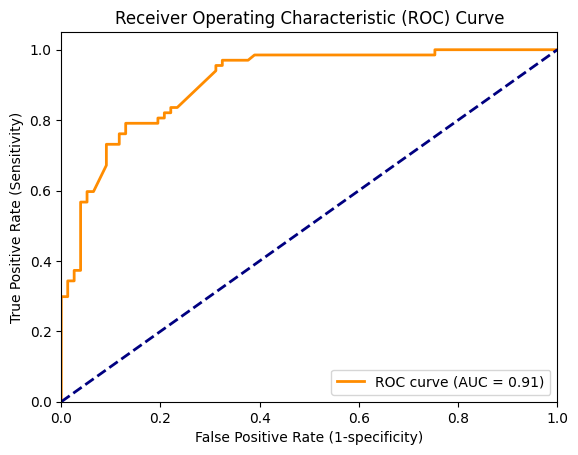

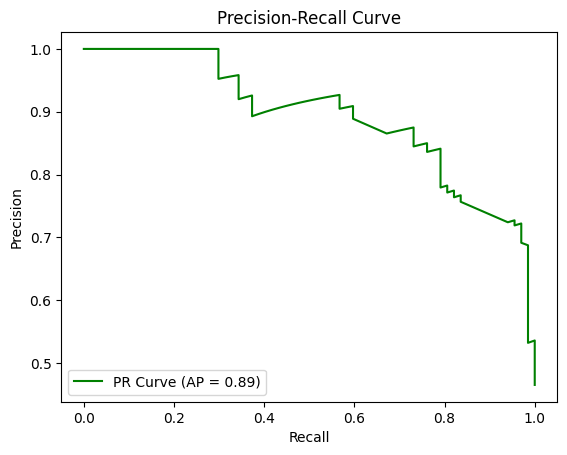

Optimization terminated successfully.
         Current function value: 0.414913
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17
         Hessian evaluations: 13
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  448
Model:                          Logit   Df Residuals:                      442
Method:                           MLE   Df Model:                            5
Date:                Sun, 13 Apr 2025   Pseudo R-squ.:                  0.4005
Time:                        10:44:51   Log-Likelihood:                -185.88
converged:                       True   LL-Null:                       -310.08
Covariance Type:            nonrobust   LLR p-value:                 1.209e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [436]:
classification_evaluator_log_reg_sig_covs = LogisticRegressionClassificationEvaluator(model=log_reg_sig_covs,
                                                                     x_evaluation_preprocessed=X_val_preprocessed[:, sig_covs-1],
                                                                     y_evaluation_cleaned=y_val_cleaned,
                                                                     feature_names=sig_covs,
                                                                     stats_model=sm.Logit(y_train_cleaned, sm.add_constant(X_train_preprocessed[:, sig_covs-1])))
                                                            
classification_evaluator_log_reg_sig_covs.get_all_classification_metrics()

### Bayesian Logistic Regression Classification

The following class implements Bayesian Logistic Regression using the Laplace approximation and exposes a class interface similar to sklearn's implementation of classifiers. It inherits from the base classifier class part of the sklearn package. It extends from that in the sense that after fitting, it is able to provide a pandas dataframe of the summary of the fitted model including coefficients and the 95% confidence interval for the parameter estimate. It also automatically calculates model evidence while fitting to data.

In [515]:
class BayesianLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, beta_0, m_0, sigma_0_inv, maxiter = 100, tolerance = 1e-05, fit_intercept = True, unit_information_prior = True, verbose = 1):
        self.fit_intercept = fit_intercept
        self.beta_0 = beta_0 # beta_0 is where to start the iterative update of the algorithm. This doesn't affect the prior, but is a numerical helper, NOT statistical assumption.
        self.m_0 = m_0 # m_0 is the prior mean of the distribution over weights beta.
        self.sigma_0_inv = sigma_0_inv # Prior precision matrix
        self.maxiter = maxiter
        self.tolerance = tolerance
        self.unit_information_prior = unit_information_prior
        self.verbose = verbose
    
    def __log_likelihood(self, X, y, beta):
        log_likelihood = y.T @ np.log(expit(X @ beta)) + (1 - y).T @ np.log(1 - expit(X @ beta))
        return log_likelihood

    def __log_likelihood_derivative(self, X, y, beta):
        log_likelihood_derivative =  X.T @ (expit(X @ beta) - y)
        return log_likelihood_derivative

    def __log_likelihood_second_derivative(self, X, y, beta):
        S = np.diag(expit(X @ beta) * (1 - expit(X @ beta)))
        Hessian = X.T @ S @ X
        return Hessian
    
    def __log_posterior(self, X, y, beta):
        log_likelihood = self.__log_likelihood(X, y, beta)
        log_prior = - 0.5 * (beta - self.m_0).T @ self.sigma_0_inv @ (beta - self.m_0)
        return log_likelihood + log_prior
    
    def __neg_log_posterior(self, X, y, beta):
        log_posterior = self.__log_posterior(X, y, beta)
        return -log_posterior
    
    def __log_posterior_derivative(self, X, y, beta):
        log_posterior_derivative = X.T @ (y - expit(X @ beta)) + self.sigma_0_inv @ (beta - self.m_0)
        return log_posterior_derivative
    
    def __neg_log_posterior_derivative(self, X, y, beta):
        log_posterior_derivative = self.__log_posterior_derivative(X, y, beta)
        return -log_posterior_derivative
    
    def __log_posterior_second_derivative(self, X, y, beta):
        S = np.diag(expit(X @ beta) * (1 - expit(X @ beta)))
        log_posterior_second_derivative = - (X.T @ S @ X) - self.sigma_0_inv
        return log_posterior_second_derivative

    def __neg_log_posterior_second_derivative(self, X, y, beta):
        log_posterior_second_derivative = self.__log_posterior_second_derivative(X, y, beta)
        return - log_posterior_second_derivative
    
    def __newton_raphson_optimization(self, X, y):
        i = 0
        beta = self.beta_0
        neg_log_posterior = self.__neg_log_posterior(X, y, beta)
        abs_diff = 1
        while abs_diff > self.tolerance and i < self.maxiter:
            if self.verbose == 1: print('iteration ',i+1,' Negative Log Posterior ',neg_log_posterior, ' AbDiff ', abs_diff)
            neg_log_posterior_derivative = self.__neg_log_posterior_derivative(X, y, beta)
            neg_log_posterior_hessian = self.__neg_log_posterior_second_derivative(X, y, beta)
            neg_log_posterior_hessian_inverse = sc.linalg.inv(neg_log_posterior_hessian)
            beta = beta - neg_log_posterior_hessian_inverse @ neg_log_posterior_derivative

            neg_log_posterior_new = self.__neg_log_posterior(X, y, beta)
            abs_diff = np.abs(neg_log_posterior_new - neg_log_posterior)
            neg_log_posterior = neg_log_posterior_new
            i += 1
            
        if (i == self.maxiter):
            print('Did not Converge') 
        
        return beta, neg_log_posterior_hessian_inverse, True
    
    def __calculate_model_evidence(self, X, y):
        log_likelihood = self.__log_likelihood(X, y, self.beta_map)
        log_prior = -0.5 * (self.beta_map - self.m_0).T @ self.sigma_0_inv @ (self.beta_map - self.m_0) \
            + 0.5 * np.linalg.slogdet(self.sigma_0_inv)[1] \
            - 0.5 * len(self.beta_map) * np.log(2 * np.pi)
            
        hessian = self.__neg_log_posterior_second_derivative(X, y, self.beta_map)
        log_det_hessian = np.linalg.slogdet(hessian)[1]
        normalization = 0.5 * (len(self.beta_map) * np.log(2*np.pi) - log_det_hessian)
        log_evidence = log_likelihood + log_prior + normalization
        return log_evidence
    
    def get_summary(self):
        check_is_fitted(self)
        se = np.sqrt(np.diag(self.sigma_map))
        lower5 = self.beta_map - 1.96 * se
        upper5 = self.beta_map + 1.96 * se
        
        results = np.column_stack([self.beta_map ,se ,lower5 ,upper5])
        col = ['post mean','post se','lower 5% bound','upper 95% bound']
        summary = pd.DataFrame(results, columns=col, index=[f'x{j+1}' for j in range(len(self.beta_map))])
        return summary
        
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        if self.unit_information_prior:
            self.sigma_0_inv = (X.T @ X) / X.shape[0]
        
        beta_map, sigma_map, converged = self.__newton_raphson_optimization(X, y)
        if converged:
            self.beta_map = beta_map
            self.sigma_map = sigma_map
            self.log_model_evidence = self.__calculate_model_evidence(X, y)
            self.coef_ = beta_map
            self.fitted_ = True
        return self

    def predict_proba(self, X, n_samples = 10000):
        check_is_fitted(self)
        X = check_array(X)
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])
            
        beta_map_samples = np.random.multivariate_normal(self.beta_map, self.sigma_map, size=n_samples)
        logits = X @ beta_map_samples.T
        probabilities = expit(logits)
        mean_probs = probabilities.mean(axis=1)
        return np.vstack([1 - mean_probs, mean_probs]).T
    
    def predict(self, X, n_samples = 10000):
        check_is_fitted(self)
        proba = self.predict_proba(X, n_samples=n_samples)
        return (proba[:, 1] >= 0.5).astype(int)

#### Bayesian Model Evidence

We utiise the above class's capabilities of calculating model evidence along with a function to automatically select the set of covariates which maximize the marginal log likelihood of the model i.e. the log evidence. The function randomly selects a set of covariates, and fits them on the training dataset. We then calculate the marginal log likelihood of the Laplace Approximation, and use the model maximizing this.

In [516]:
best_evidence, best_feature_subset, _, _ = bayesian_model_evidence_selection(full_pipeline, 
                                                                            X_train_cleaned, 
                                                                            y_train_cleaned, 
                                                                            BayesianLogisticRegression,
                                                                            num_models=10
                                                                            )

print("Best Model Evidence:", best_evidence)
print("Best Feature Subset:", best_feature_subset)

Finished calculating evidence for subset number: 1
Finished calculating evidence for subset number: 2
Finished calculating evidence for subset number: 3
Finished calculating evidence for subset number: 4
Finished calculating evidence for subset number: 5
Finished calculating evidence for subset number: 6
Finished calculating evidence for subset number: 7
Finished calculating evidence for subset number: 8
Finished calculating evidence for subset number: 9
Finished calculating evidence for subset number: 10
Best Model Evidence: -176.58991737930305
Best Feature Subset: [0, 2, 3, 4, 5, 8, 10, 11, 12, 14]


#### Refitting model with highest marginal likelihood on training set and evaluating performance on validation

We use the model using only the covariates producing the highest marginal log likelihood. We see it's performance on the validation set

In [517]:
blr = BayesianLogisticRegression(beta_0 = np.zeros(len(best_feature_subset) + 1),
                                 m_0 = np.zeros(len(best_feature_subset) + 1),
                                 sigma_0_inv= (X_train_preprocessed[:, best_feature_subset].T @ X_train_preprocessed[:, best_feature_subset])/ X_train_preprocessed.shape[0],
                                 maxiter=100,
                                 tolerance=1e-05,
                                 fit_intercept=True,
                                 verbose=0
                                )

blr.fit(X_train_preprocessed[:, best_feature_subset], y_train_cleaned)

BayesianLogisticRegression(beta_0=array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       0.0000, 0.0000, 0.0000]),
                           m_0=array([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       0.0000, 0.0000, 0.0000]),
                           sigma_0_inv=array([[1.0000, 0.7522, 0.1496, 0.2388, 0.2321, 0.0513, 0.4933, 0.1680,
        0.4177, 0.7619, 0.0028],
       [0.7522, 0.7522, 0.1339, 0.1562, 0.1674, 0.0379...
        0.2051, 0.3847, 0.0020],
       [0.1680, 0.1286, 0.0263, 0.0376, 0.0402, 0.0086, 0.0839, 0.0297,
        0.0717, 0.1267, 0.0005],
       [0.4177, 0.3187, 0.0636, 0.0976, 0.0976, 0.0225, 0.2051, 0.0717,
        0.1792, 0.3143, 0.0012],
       [0.7619, 0.5707, 0.1160, 0.1799, 0.1732, 0.0371, 0.3847, 0.1267,
        0.3143, 0.5866, 0.0022],
       [0.0028, 0.0023, 0.0005, 0.0002, 0.0006, 0.0002, 0.0020, 0.0005,
        0.0012, 0.0022, 0.0000]]),
                           verbose=0)

{'Accuracy': 0.8819444444444444, 'Balanced accuracy': 0.8818569490211281, 'Precision': 0.8676470588235294, 'Sensivity/Recall': 0.8805970149253731, 'Specificity': 0.8831168831168831, 'False Alarm Rate': 0.11688311688311688, 'F1 Score': 0.8740740740740741}


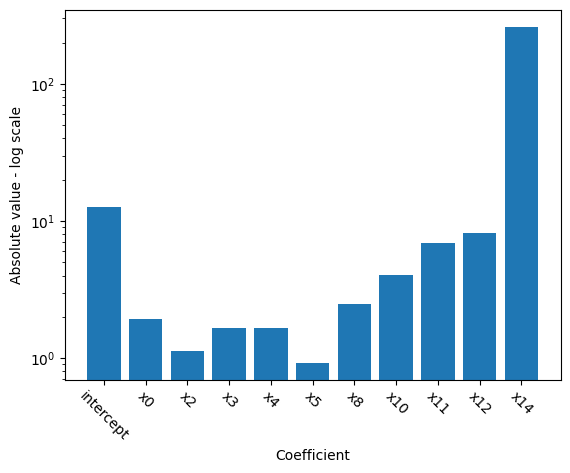

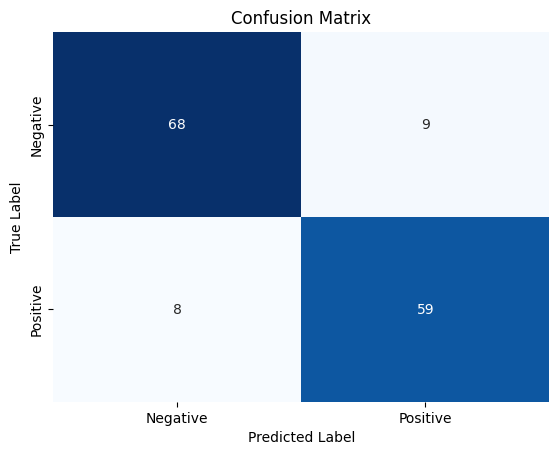

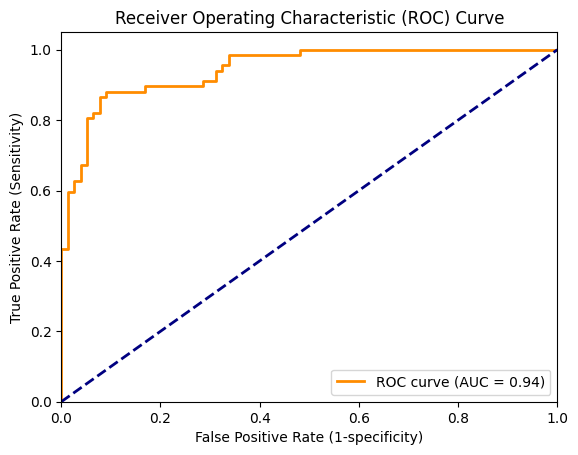

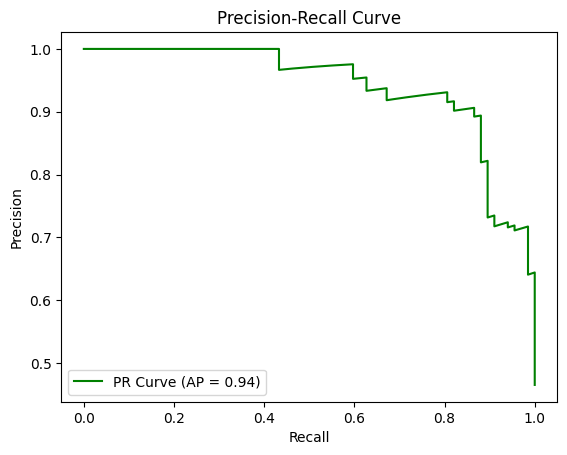

      post mean    post se  lower 5% bound  upper 95% bound
x1   -12.696596   3.799555      -20.143724        -5.249467
x2     1.938075   0.377064        1.199030         2.677120
x3     1.122523   0.443282        0.253690         1.991356
x4    -1.659284   0.422464       -2.487315        -0.831254
x5    -1.651067   0.379183       -2.394266        -0.907867
x6    -0.926312   0.673087       -2.245563         0.392939
x7     2.484093   0.326611        1.843936         3.124250
x8     4.030073   4.869249       -5.513655        13.573800
x9     6.862951   3.674802       -0.339661        14.065563
x10    8.121757   3.296344        1.660922        14.582591
x11  260.585803  53.664513      155.403358       365.768248



In [519]:
classification_evaluator_blr = BayesianLogisticRegressionClassificationEvaluator(
                                                                            model=blr,
                                                                            X_evaluation_preprocessed=X_val_preprocessed[:, best_feature_subset],
                                                                            y_evaluation_cleaned=y_val_cleaned,
                                                                            feature_names=pd.Index([f'x{i}' for i in best_feature_subset]),
                                                                        )

classification_evaluator_blr.get_all_classification_metrics()

## Final Model Evaluation

The best model we found was the Bayesian Logistic Regression classifier with the feature subset having the highest marginal likelihood. The validation set ROC AUC was 0.94, and the area under Precision-Recall curve was also 0.94. This model also had an F1-score of 0.87, which was higher than the ones produced by Logistic Regression and Gaussian Process Classifier which were ~0.80 and ~0.85 respectively. The Bayesian Logistic Regression model has beaten other models on most of the classification metrics, and we can see this visually via the confusion matrix.

We now evaluate the same performance on the final unseen test set, which is unseen from the beginning.

{'Accuracy': 0.8116883116883117, 'Balanced accuracy': 0.8124050632911393, 'Precision': 0.7875, 'Sensivity/Recall': 0.84, 'Specificity': 0.7848101265822784, 'False Alarm Rate': 0.21518987341772153, 'F1 Score': 0.8129032258064516}


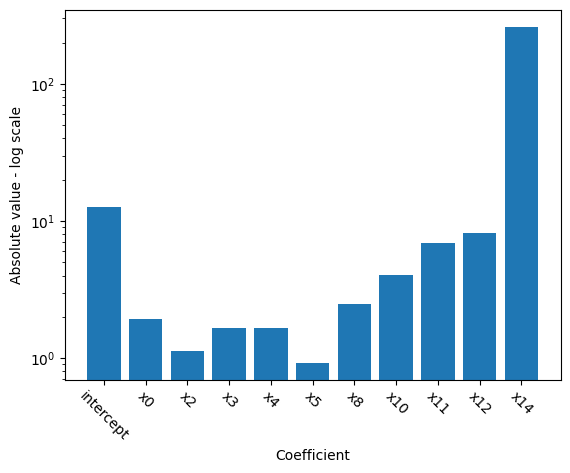

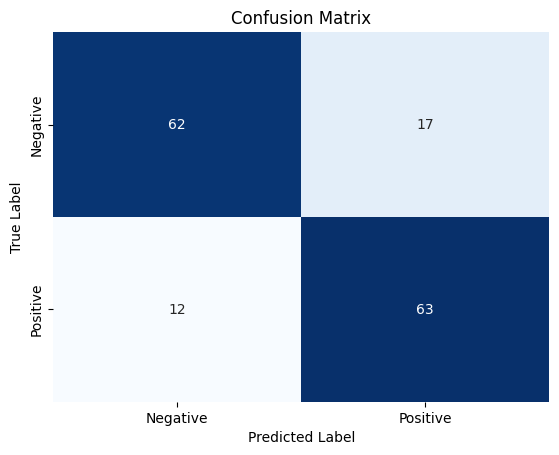

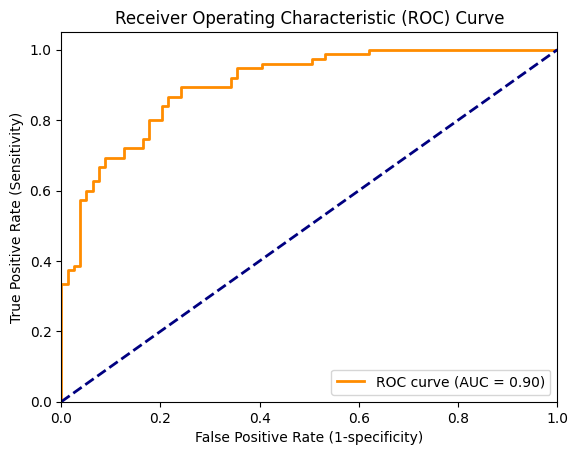

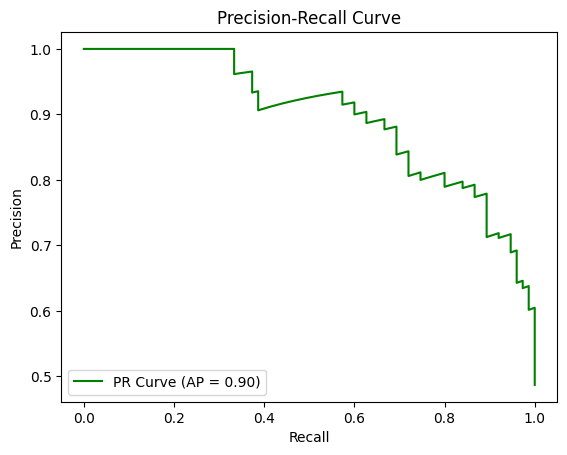

      post mean    post se  lower 5% bound  upper 95% bound
x1   -12.696596   3.799555      -20.143724        -5.249467
x2     1.938075   0.377064        1.199030         2.677120
x3     1.122523   0.443282        0.253690         1.991356
x4    -1.659284   0.422464       -2.487315        -0.831254
x5    -1.651067   0.379183       -2.394266        -0.907867
x6    -0.926312   0.673087       -2.245563         0.392939
x7     2.484093   0.326611        1.843936         3.124250
x8     4.030073   4.869249       -5.513655        13.573800
x9     6.862951   3.674802       -0.339661        14.065563
x10    8.121757   3.296344        1.660922        14.582591
x11  260.585803  53.664513      155.403358       365.768248



In [520]:
classification_evaluator_blr = BayesianLogisticRegressionClassificationEvaluator(
                                                                            model=blr,
                                                                            X_evaluation_preprocessed=X_test_preprocessed[:, best_feature_subset],
                                                                            y_evaluation_cleaned=y_test_cleaned,
                                                                            feature_names=pd.Index([f'x{i}' for i in best_feature_subset]),
                                                                        )

classification_evaluator_blr.get_all_classification_metrics()